# Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import pdb

import keras.backend as K
from keras import losses
from keras.models import Sequential, Input, Model
from keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D
from keras.utils import np_utils

# Distinguish Gaussians from Lorentzians, and predicting the mean, standard deviation if Gaussian

## Plot CNN results

In [3]:
def predict(model):
    #pdb.set_trace()
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000)
    
    # Apply the model to get predicted means and sigmas of the Gaussians
    pmeans, psigs = model.predict(predX, batch_size=None, verbose=0)
    
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(211)
    _, _, _ = plt.hist(predy[:, 0] - pmeans.flatten(), bins=30)
    plt.subplot(212)
    _, _, _ = plt.hist(predy[:, 1] - psigs.flatten(), bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    plt.subplot(211)
    # Plot the true y's and predicted y's from the NN model
    plt.plot(predy[:, 0], pmeans.flatten(), marker='.')
    # Plot the 1-to-1 line
    plt.plot(oto_means, oto_means, color='black', ls='--')
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\mu$')
    
    plt.subplot(212)
    plt.plot(predy[:, 1], psigs.flatten(), marker='.')
    plt.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    plt.xlim(0.25, 4.0)
    plt.ylim(0.25, 4.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\sigma$')
    
    #plt.savefig('gaussian_characteristics.pdf')
    plt.show()

## Generate distributions

### 1D Gaussian

In [4]:
# Calculate a Gaussian given its mean and standard deviation
def gaussian(x_vals, mu, sigma):
    return np.exp(-0.5 * ((x_vals - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))

# Make array that describes Gaussian
def make_gaussians(num, mu_min=-1.0, mu_max=1.0, sig_min=0.25, sig_max=4.0): 

    means = np.random.uniform(mu_min, mu_max, num)
    sigmas = np.random.uniform(sig_min, sig_max, num)

    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))

    for i in range(num):
        models[i] = gaussian(x_vals, means[i], sigmas[i])
    
    # Also want to save and return the true means, sigmas used for the Gaussians
    targets = np.vstack((means, sigmas)).T
    
    models = models.reshape(num, 32, 1)

    return models, targets

### 1D Lorentzian

In [5]:
# Calculate a Lorentzian distribution given its location parameter and scale parameter
def lorentzian(x_vals, loc, scale):
    return ( 1/(np.pi*scale) ) * ( scale**2 / ((x_vals - loc)**2 + (scale)**2) )

def make_lorentzians(num, loc_min=-1.0, loc_max=1.0, scale_min=0.25, scale_max=4.0):
    
    locs = np.random.uniform(loc_min, loc_max, num)
    scales = np.random.uniform(scale_min, scale_max, num)
    
    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))
    
    for i in range(num):
        models[i] = lorentzian(x_vals, locs[i], scales[i])
        
    targets = np.vstack((locs, scales)).T
    
    models = models.reshape(num, 32, 1)
    
    return models, targets

#### Plot to check Lorentzian function

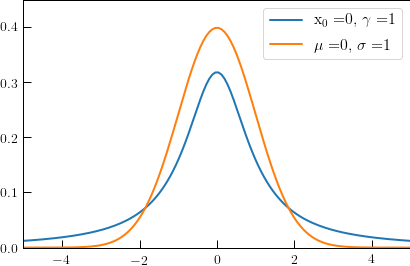

In [6]:
x_vals = np.linspace(-10.0, 10.0, 2**8)

plt.plot(x_vals, lorentzian(x_vals, 0.0, 1.0), label=r'x$_{0}=$0, $\gamma=$1')
plt.plot(x_vals, gaussian(x_vals, 0.0, 1.0), label=r'$\mu=$0, $\sigma=$1')
plt.xlim(-5, 5)
plt.ylim(0.0, 0.45)
plt.legend(fontsize=16)

plt.show()

# Just Classification

## Generate dataset

In [ ]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000, frac_gauss=None):
    # From desired training and test set sizes, determine the fraction that is Gaussian vs Lorentzian
    
    # Random fraction w/limits to avoid too many of any one kind
    if frac_gauss is None:
        fg_train = np.random.uniform(0.25, 0.75)
        fg_test = np.random.uniform(0.25, 0.75)
    
    # User-identified fraction
    elif frac_gauss < 1.0:
        fg_train = fg_test = frac_gauss
        
    num_gauss_train = int(fg_train * n_train)
    num_gauss_test =  int(fg_test * n_test)
    
    num_lorentz_train = n_train - num_gauss_train
    num_lorentz_test = n_test - num_gauss_test
    
    print (num_gauss_train, num_lorentz_train, num_gauss_test, num_lorentz_test)

    # Generate training and test sets
    X_train_gauss, _ = make_gaussians(num_gauss_train)
    X_test_gauss, _  = make_gaussians(num_gauss_test)

    X_train_lorentz, _ = make_lorentzians(num_lorentz_train)
    X_test_lorentz, _ = make_lorentzians(num_lorentz_test)
    
    # Classification
    y_train = np.ones(n_train)
    y_train[0:num_gauss_train] *= 0.0 # Gaussians are 0s
    y_train = np_utils.to_categorical(y_train)
    
    y_test = np.ones(n_test)
    y_test[0:num_gauss_test] *= 0.0 # Gaussians are 0s
    y_test = np_utils.to_categorical(y_test)

    # Combine Gaussian and Lorentzians
    X_train = np.concatenate((X_train_gauss, X_train_lorentz))
    X_test = np.concatenate((X_test_gauss, X_test_lorentz))
    
    return X_train, y_train, X_test, y_test

## Create, compile, fit, and evaluate NN model

In [ ]:
# Create dataset
X_train, y_train, X_test, y_test = generate_dataset()

In [ ]:
# Define baseline model
def baseline_model():
    # Create model
#    model = Sequential()
#    model.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    # There are 2 classes -- Gaussian or Lorentzian -- hence the Dense(2)
#    model.add(Dense(2, kernel_initializer='normal', activation='softmax')) 
    
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(32, activation='relu')(inputs)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
# Build the model
model = baseline_model()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
history.history.keys()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'test'], loc='upper right')

fig.show()

In [ ]:
_, _, new_X, new_y = generate_dataset(n_train=10, n_test=1000)
new_pred_y = model.predict(new_X)
#new_pred_y = model.evaluate(new_X, new_y, verbose=1)

print (new_pred_y)#, np.argmax(new_pred_y, axis=1))

# Classify and Regress

Custom Keras loss function that conditionally creates a zero gradient: https://stackoverflow.com/questions/54031644/custom-keras-loss-function-that-conditionally-creates-a-zero-gradient

In [7]:
# Create training and test sets
def generate_dataset_wparams(n_train=10000, n_test=1000, frac_gauss=None):
    # From desired training and test set sizes, determine the fraction that is Gaussian vs Lorentzian
    
    # Random fraction w/limits to avoid too many of any one kind
    if frac_gauss is None:
        fg_train = np.random.uniform(0.25, 0.75)
        fg_test = np.random.uniform(0.25, 0.75)
    
    # User-identified fraction
    elif frac_gauss < 1.0:
        fg_train = fg_test = frac_gauss
        
    num_gauss_train = int(fg_train * n_train)
    num_gauss_test =  int(fg_test * n_test)
    
    num_lorentz_train = n_train - num_gauss_train
    num_lorentz_test = n_test - num_gauss_test
    
    print (num_gauss_train, num_lorentz_train, num_gauss_test, num_lorentz_test)

    # Generate training and test sets
    X_train_gauss, y_train_gauss = make_gaussians(num_gauss_train)
    X_test_gauss, y_test_gauss = make_gaussians(num_gauss_test)

    X_train_lorentz, y_train_lorentz = make_lorentzians(num_lorentz_train)
    X_test_lorentz, y_test_lorentz = make_lorentzians(num_lorentz_test)

    # Combine Gaussian and Lorentzians
    X_train = np.concatenate((X_train_gauss, X_train_lorentz))
    y_train = np.concatenate((y_train_gauss, y_train_lorentz))
    X_test = np.concatenate((X_test_gauss, X_test_lorentz))
    y_test = np.concatenate((y_test_gauss, y_test_lorentz))
    
    # Want to classify the arrays too...?
    # Classification
    class_train = np.ones(n_train)
    class_train[0:num_gauss_train] *= 0.0 # Gaussians are 0s
    #class_train = np_utils.to_categorical(class_train)
    
    class_test = np.ones(n_test)
    class_test[0:num_gauss_test] *= 0.0 # Gaussians are 0s
    #class_test = np_utils.to_categorical(class_test)    

    return X_train, y_train, X_test, y_test, class_train, class_test

In [8]:
# Create dataset
X_train, y_train, X_test, y_test, class_train, class_test = generate_dataset_wparams()

4939 5061 442 558


In [57]:
# https://stackoverflow.com/questions/54031644/custom-keras-loss-function-that-conditionally-creates-a-zero-gradient

def custom_loss():
    def loss(y_true, y_pred):
    # Want a loss that returns loss = 0.0 if the class is a Lorentzian (value of 1)
        loss_val = losses.mean_squared_error(y_true, y_pred)
        # K.switch(condition, then expression, else expression)
        # If y_true is 0, then return a loss, else return 0.0
        #pdb.set_trace()
        
        return K.switch(K.flatten(K.equal(y_true[:,0], 0.)), loss_val, K.zeros_like(loss_val))
    
    # Return a function
    return loss

In [50]:
# Define baseline model
def baseline_model():
    # Create model
    verbose, epochs, batch_size = 1, 100, 16
    input_shape = X_train.shape[1]

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    x = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
    x = Conv1D(filters=8, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)    
    
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    
    classify = Dense(1, activation='sigmoid', name='type')(x)
    regress1 = Dense(1, activation='linear', name='param1')(x)
    regress2 = Dense(1, activation='linear', name='param2')(x)
    
    # Create model with input layer and dense layers
    model = Model(inputs=inputs, outputs=[classify, regress1, regress2])
    #model.compile(loss=[custom_loss(), custom_loss(), custom_loss()], optimizer='rmsprop')
    model.compile(loss=['binary_crossentropy', 'mse', 'mse'], optimizer='rmsprop')
    
    return model

In [51]:
verbose, epochs, batch_size = 1, 100, 16

# Build the model
model = baseline_model()

# Fit the model
history = model.fit(X_train, [np.vstack(class_train), y_train[:,0], y_train[:,1]], epochs=epochs, verbose=verbose)

# Final evaluation of the model
scores = model.evaluate(X_test, [np.vstack(class_test), y_test[:,0], y_test[:,1]], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/100
10000/10000 [==============================] - 1s 128us/step - loss: 1.2857 - type_loss: 0.6552 - param1_loss: 0.1247 - param2_loss: 0.5052
Epoch 2/100
10000/10000 [==============================] - 1s 99us/step - loss: 0.6249 - type_loss: 0.5132 - param1_loss: 0.0139 - param2_loss: 0.0974
Epoch 3/100
10000/10000 [==============================] - 1s 100us/step - loss: 0.3331 - type_loss: 0.2610 - param1_loss: 0.0087 - param2_loss: 0.0634
Epoch 4/100
10000/10000 [==============================] - 1s 99us/step - loss: 0.1639 - type_loss: 0.1134 - param1_loss: 0.0077 - param2_loss: 0.0428
Epoch 5/100
10000/10000 [==============================] - 1s 101us/step - loss: 0.1068 - type_loss: 0.0627 - param1_loss: 0.0087 - param2_loss: 0.0353
Epoch 6/100
10000/10000 [==============================] - 1s 102us/step - loss: 0.0827 - type_loss: 0.0434 - param1_loss: 0.0083 - param2_loss: 0.0309
Epoch 7/100
10000/10000 [==============================] - 1s 99us/step - loss: 0.0651 - t

10000/10000 [==============================] - 1s 98us/step - loss: 0.0042 - type_loss: 2.3596e-05 - param1_loss: 6.3848e-04 - param2_loss: 0.0036
Epoch 54/100
10000/10000 [==============================] - 1s 97us/step - loss: 0.0041 - type_loss: 2.5124e-05 - param1_loss: 6.3742e-04 - param2_loss: 0.0034
Epoch 55/100
10000/10000 [==============================] - 1s 97us/step - loss: 0.0041 - type_loss: 1.8425e-04 - param1_loss: 6.0086e-04 - param2_loss: 0.0033
Epoch 56/100
10000/10000 [==============================] - 1s 97us/step - loss: 0.0040 - type_loss: 2.0613e-04 - param1_loss: 5.8632e-04 - param2_loss: 0.0032
Epoch 57/100
10000/10000 [==============================] - 1s 97us/step - loss: 0.0038 - type_loss: 1.8391e-05 - param1_loss: 5.7461e-04 - param2_loss: 0.0032
Epoch 58/100
10000/10000 [==============================] - 1s 97us/step - loss: 0.0039 - type_loss: 4.0111e-05 - param1_loss: 5.5922e-04 - param2_loss: 0.0033
Epoch 59/100
10000/10000 [===========================

In [52]:
_, _, new_X, new_y, new_ctr, new_cte = generate_dataset_wparams(n_train=10, n_test=100)
new_pred_y = model.predict(new_X)

3 7 69 31


In [53]:
new_ctr, new_cte

(array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

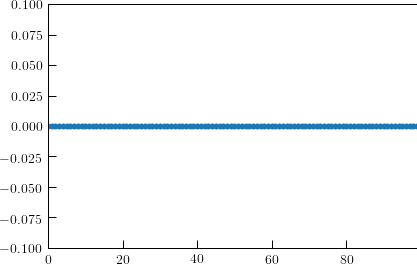

In [56]:
plt.plot(new_pred_y[0].flatten()- new_cte, 'o')
plt.ylim(-0.1, 0.1)
plt.show()

# Following classification+regression (gender+age) problem from online

Classify and regress at the same time: https://stats.stackexchange.com/questions/77330/classify-and-regress-at-the-same-time

In [ ]:
import pandas as pd

adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
adult.columns = ['age', 'workclass', 'fnlwgt', 'edu', 'edu_num', 'marital_status',
                 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                 'hours_per_week', 'native_country', 'income']
adult["sex"] = adult["sex"].astype('category').cat.codes
adult["workclass"] = adult["workclass"].astype('category').cat.codes
adult["marital_status"] = adult["marital_status"].astype('category').cat.codes
adult["race"] = adult["race"].astype('category').cat.codes
adult["occupation"] = adult["occupation"].astype('category').cat.codes
adult["native_country"] = adult["native_country"].astype('category').cat.codes

target_bin = adult[['sex']].values.astype('float32') # 0 is female?
target_num = adult[['age']].values.astype('float32')
X = adult[['workclass', 'edu_num', 'marital_status', 'occupation', 'race', 'capital_gain',
           'capital_loss', 'hours_per_week', 'native_country']].values.astype('float32')

In [ ]:
adult.head()

In [ ]:
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

inputs = Input(shape=(X.shape[1],), name='Input')

hidden = Dense(64, name='Shared-Hidden-Layer', activation='relu')(inputs)
hidden = BatchNormalization()(hidden)
out_bin = Dense(1, name='Output-Bin', activation='sigmoid')(hidden)
out_num = Dense(1, name='Output-Num', activation='linear')(hidden)

model = Model(inputs, [out_bin, out_num])
model.compile(optimizer=Adam(0.10), loss=['binary_crossentropy', 'mean_squared_error'])
model.summary()

#plot_model(model)

In [ ]:
model.fit(X, [target_bin, target_num], validation_split=.20, epochs=100, batch_size=2048)

In [ ]:
gend = model.predict(X)

In [ ]:
print ('Fraction incorrectly gendered:', 100*len(np.where(np.around(gend[0].flatten()) - target_bin.flatten() != 0.)[0]) / len(target_bin.flatten()))

# Testing custom loss functions

In [ ]:
from keras import backend as K
from keras import losses

def custom_loss(y_true, y_pred):
    loss = losses.mean_squared_error(y_true, y_pred)
    pdb.set_trace()
    return K.switch(K.flatten(K.equal(y_true, 0.)), K.zeros_like(loss), loss)

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(1, input_shape=(1,)))

model.compile(loss=custom_loss, optimizer='adam')

weights, bias = model.layers[0].get_weights()

x = np.array([1, 2, 3])
y = np.array([0, 0, 0])

model.train_on_batch(x, y)

In [ ]:
 tf.keras.losses.mean_squared_error(tf.ones((2, 2,)), tf.zeros((2, 2)))

In [ ]:
K.equal(x, 0)